# Mounting GDrive directory

In [112]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Colab Notebooks/UoA_MSDS/Course_8/Capstone1_Ad_Campaign_Recommender/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/UoA_MSDS/Course_8/Capstone1_Ad_Campaign_Recommender


# Import libraries

In [113]:
import os
import csv

from IPython.core.display import display, HTML

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pickle

from sklearn import metrics
from scipy import stats

# Reading data

In [114]:
# Load into dataframes, disble quote parsing inside strings when loading
# Ref: https://stackoverflow.com/a/29857126

# Scenario 1: devices with event data
segment_1_train = pd.read_csv('data/train/segment_1_train.csv')
segment_1_test = pd.read_csv('data/test/segment_1_test.csv')

with open('deploy/gender_model_sc1_fit.pickle', 'rb') as f:
  gender_model_sc1_fit = pickle.load(f)
with open('deploy/age_model_sc1_fit.pickle', 'rb') as f:
  age_model_sc1_fit = pickle.load(f)

# Scenario 2: devices without event data
segment_2_train = pd.read_csv('data/train/segment_2_train.csv')
segment_2_test = pd.read_csv('data/test/segment_2_test.csv')

with open('deploy/gender_model_sc2_fit.pickle', 'rb') as f:
  gender_model_sc2_fit = pickle.load(f)
with open('deploy/age_model_sc2_fit.pickle', 'rb') as f:
  age_model_sc2_fit = pickle.load(f)

# Subtask 6: Model evaluation

## 1. Common functions for evaluation

In [115]:
def display_classification_report(y_true, y_pred, clf):
    display(HTML('<h2>Confusion matrix:</h2>'))
    print(metrics.classification_report(
        y_true.values.flatten(),
        y_pred,
        target_names=list(map(lambda cls: f'class {cls}', clf.classes_))),
    )

In [116]:
def display_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.roc_auc_score(y_true, y_pred)
    display(HTML(f'<h2>AuC score: {roc_auc}</h2>'))
    display(HTML('<h2>ROC curve:</h2>'))
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    disp.plot()
    plt.show()

In [117]:
# Reference: https://towardsdatascience.com/evaluating-classification-models-with-kolmogorov-smirnov-ks-test-e211025f5573
def display_kolmogorov_smirnov_statistic(y_true, y_pred_proba, clf):
    display(HTML('<h2>Kolmogorov–Smirnov (KS) statistic:</h2>'))
    for cls in clf.classes_:
        df = pd.DataFrame()
        df['real'] = y_true
        df['proba'] = y_pred_proba[:, cls]

        # Recover each class
        target_cls = df[df['real'] == cls]['proba']
        other_cls = df[df['real'] != cls]['proba']
        ks_score = stats.ks_2samp(target_cls, other_cls)
        ks_score = dict(
            statistic=ks_score.statistic,
            pvalue=ks_score.pvalue,
            statistic_location=ks_score.statistic_location,
            statistic_sign=ks_score.statistic_sign
        )
        ks_score = pd.DataFrame(ks_score, index=[0])
        display(HTML(f'<h3>class {cls} vs others:</h3>'))
        display(ks_score)

In [118]:
# Reference: https://github.com/vinyluis/Articles/blob/main/Kolmogorov-Smirnov/Kolmogorov-Smirnov%20-%20Classification.ipynb
def display_binary_probability_bands(y_true, y_pred_proba):
    display(HTML('<h2>Probability bands:</h2>'))
    sns.histplot(x=y_pred_proba[:, 1], hue=y_true.values.flatten())

In [119]:
def display_multi_label_log_loss(y_true, y_pred_proba, clf):
    display(HTML('<h2>Multi-label log loss:</h2>'))
    display(metrics.log_loss(y_true.values.flatten(), y_pred_proba))

In [120]:
def gender_model_evaluations(X, y, clf):
    y_pred = clf.predict(X)
    y_pred_proba = clf.predict_proba(X)
    display_classification_report(y, y_pred, clf)
    display_roc_curve(y, y_pred)
    display_kolmogorov_smirnov_statistic(y, y_pred_proba, clf)
    display_binary_probability_bands(y, y_pred_proba)

In [121]:
def age_model_evaluations(X, y, clf):
    y_pred = clf.predict(X)
    y_pred_proba = clf.predict_proba(X)
    display_classification_report(y, y_pred, clf)
    display_kolmogorov_smirnov_statistic(y, y_pred_proba, clf)
    display_multi_label_log_loss(y, y_pred_proba, clf)

## 2. Gender prediction model

### a) Scenario 1: Devices with event data

In [122]:
# Format train/test data
X_train = segment_1_train.drop(columns=['device_id', 'gender', 'age_group'])
y_train = segment_1_train[['gender']]
X_test = segment_1_test.drop(columns=['device_id', 'gender', 'age_group'])
y_test = segment_1_test[['gender']]

for df, label in zip(
    [
        X_train,
        y_train,
        X_test,
        y_test,
    ],
    [
        'X_train',
        'y_train',
        'X_test',
        'y_test',
    ],
):
    display(HTML(f'<h2>{label}</h2>'))
    display(df)

,average_daily_events,location_cluster_-1,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,location_cluster_5,location_cluster_6,location_cluster_7,...,app_categories_quality,app_categories_reading platform,app_categories_realistic style comic,app_categories_service,app_categories_show,app_categories_takeaway ordering,app_categories_tourism product,app_categories_travel,app_categories_video,app_categories_zombies game
0,0.380427,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.621224,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2.669088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.157734,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.123856,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2836,-0.623716,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2837,1.288079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2838,-0.705781,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2839,-0.026953,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,gender
0,1
1,1
2,1
3,1
4,0
...,...
2836,1
2837,1
2838,0
2839,1


,average_daily_events,location_cluster_-1,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,location_cluster_5,location_cluster_6,location_cluster_7,...,app_categories_quality,app_categories_reading platform,app_categories_realistic style comic,app_categories_service,app_categories_show,app_categories_takeaway ordering,app_categories_tourism product,app_categories_travel,app_categories_video,app_categories_zombies game
0,2.356397,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.523348,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.073159,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.744514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.057478,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,0.480375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1214,-0.893056,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1215,0.478324,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1216,-0.013296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,gender
0,0
1,1
2,1
3,1
4,0
...,...
1213,0
1214,0
1215,1
1216,1


#### Evaluations on train set:

              precision    recall  f1-score   support

     class 0       1.00      0.01      0.02       791
     class 1       0.72      1.00      0.84      2050

    accuracy                           0.72      2841
   macro avg       0.86      0.51      0.43      2841
weighted avg       0.80      0.72      0.61      2841



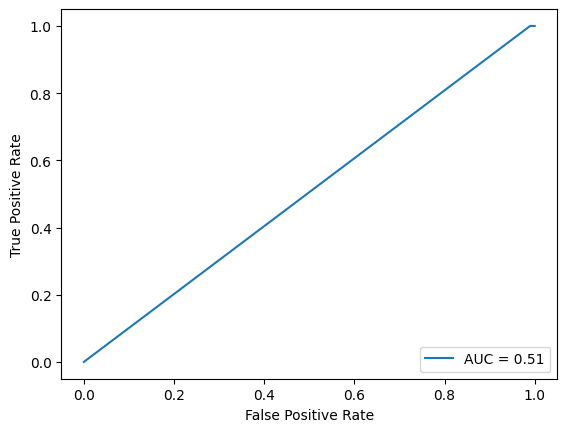

,statistic,pvalue,statistic_location,statistic_sign
0,0.312131,1.087792e-49,0.274235,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.312131,1.087792e-49,0.725739,-1


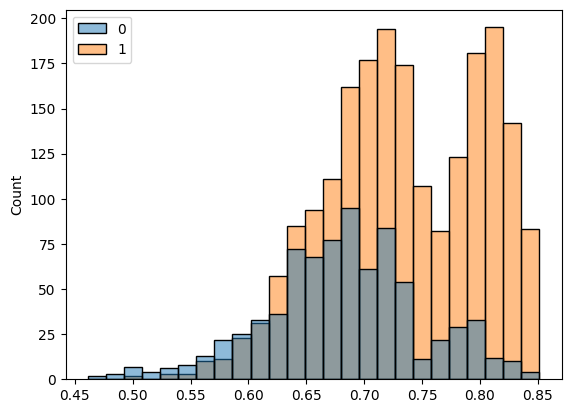

In [123]:
gender_model_evaluations(
    X_train,
    y_train,
    gender_model_sc1_fit,
)

#### Evaluations on test set:

              precision    recall  f1-score   support

     class 0       0.67      0.01      0.01       303
     class 1       0.75      1.00      0.86       915

    accuracy                           0.75      1218
   macro avg       0.71      0.50      0.44      1218
weighted avg       0.73      0.75      0.65      1218



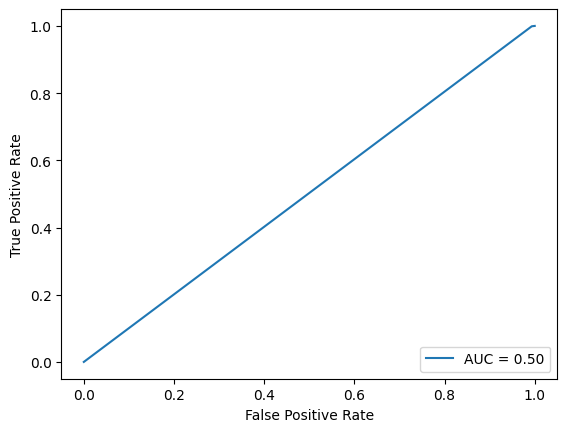

,statistic,pvalue,statistic_location,statistic_sign
0,0.189666,1.207037e-07,0.285835,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.189666,1.207037e-07,0.714125,-1


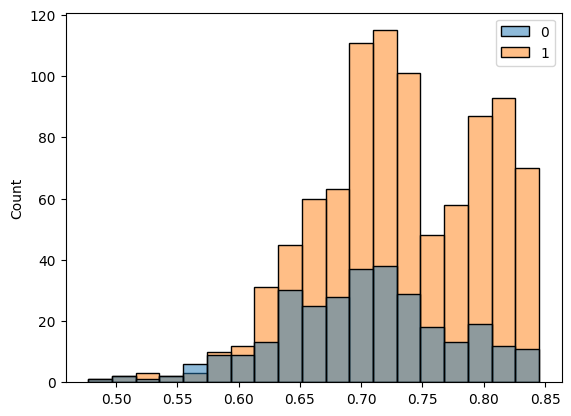

In [124]:
gender_model_evaluations(
    X_test,
    y_test,
    gender_model_sc1_fit,
)

### b) Scenario 2: Devices without event data

In [125]:
# Format train/test data
X_train = segment_2_train.drop(columns=['device_id', 'gender', 'age_group'])
y_train = segment_2_train[['gender']]
X_test = segment_2_test.drop(columns=['device_id', 'gender', 'age_group'])
y_test = segment_2_test[['gender']]

for df, label in zip(
    [
        X_train,
        y_train,
        X_test,
        y_test,
    ],
    [
        'X_train',
        'y_train',
        'X_test',
        'y_test',
    ],
):
    display(HTML(f'<h2>{label}</h2>'))
    display(df)

,phone_brand_AUX,phone_brand_Bacardi,phone_brand_Bifer,phone_brand_CUBE,phone_brand_Changhong,phone_brand_Cong,phone_brand_Coolpad,phone_brand_Ctyon,phone_brand_Daq,phone_brand_Gionee,...,phone_brand_smallt,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,gender
0,1
1,1
2,1
3,1
4,1
...,...
49541,0
49542,1
49543,1
49544,1


,phone_brand_AUX,phone_brand_Bacardi,phone_brand_Bifer,phone_brand_CUBE,phone_brand_Changhong,phone_brand_Cong,phone_brand_Coolpad,phone_brand_Ctyon,phone_brand_Daq,phone_brand_Gionee,...,phone_brand_smallt,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,gender
0,0
1,1
2,0
3,0
4,1
...,...
21230,1
21231,0
21232,0
21233,1


#### Evaluations on train set:

              precision    recall  f1-score   support

     class 0       0.71      0.01      0.02     18035
     class 1       0.64      1.00      0.78     31511

    accuracy                           0.64     49546
   macro avg       0.67      0.50      0.40     49546
weighted avg       0.66      0.64      0.50     49546



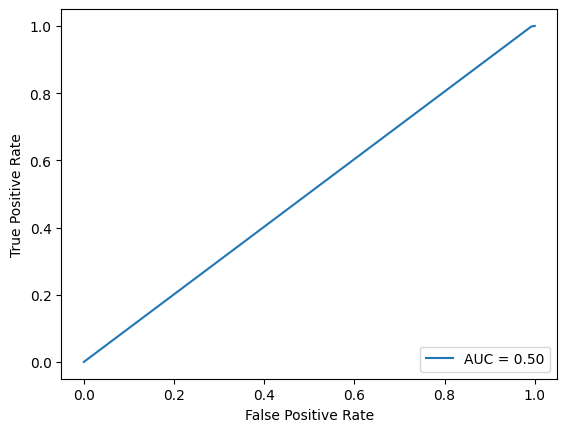

,statistic,pvalue,statistic_location,statistic_sign
0,0.101814,5.762835e-104,0.347641,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.101814,5.762835e-104,0.651273,-1


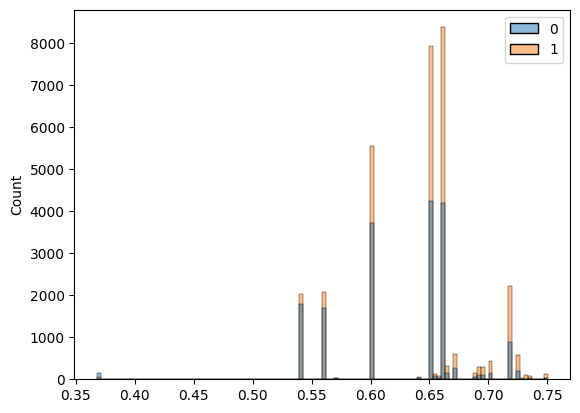

In [126]:
gender_model_evaluations(
    X_train,
    y_train,
    gender_model_sc2_fit,
)

#### Evaluations on test set:

              precision    recall  f1-score   support

     class 0       0.61      0.01      0.01      7676
     class 1       0.64      1.00      0.78     13559

    accuracy                           0.64     21235
   macro avg       0.62      0.50      0.40     21235
weighted avg       0.63      0.64      0.50     21235



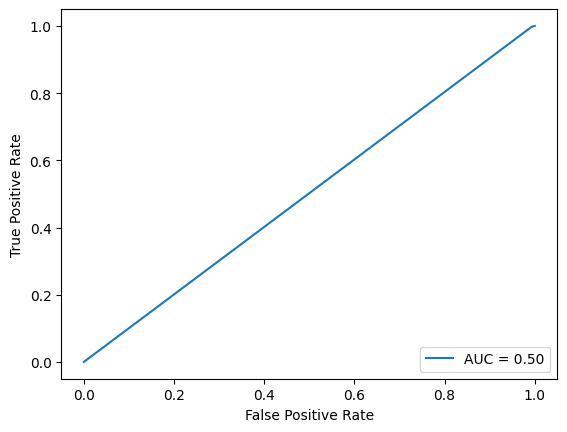

,statistic,pvalue,statistic_location,statistic_sign
0,0.105391,7.443207e-48,0.347641,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.105391,7.443207e-48,0.651273,-1


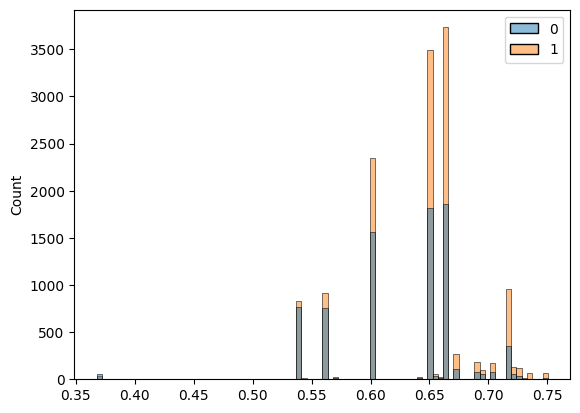

In [127]:
gender_model_evaluations(
    X_test,
    y_test,
    gender_model_sc2_fit,
)

## 3. Age group prediction model

### a) Scenario 1: Devices with event data

In [128]:
# Format train/test data
X_train = segment_1_train.drop(columns=['device_id', 'gender', 'age_group'])
y_train = segment_1_train[['age_group']]
X_test = segment_1_test.drop(columns=['device_id', 'gender', 'age_group'])
y_test = segment_1_test[['age_group']]

for df, label in zip(
    [
        X_train,
        y_train,
        X_test,
        y_test,
    ],
    [
        'X_train',
        'y_train',
        'X_test',
        'y_test',
    ],
):
    display(HTML(f'<h2>{label}</h2>'))
    display(df)

,average_daily_events,location_cluster_-1,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,location_cluster_5,location_cluster_6,location_cluster_7,...,app_categories_quality,app_categories_reading platform,app_categories_realistic style comic,app_categories_service,app_categories_show,app_categories_takeaway ordering,app_categories_tourism product,app_categories_travel,app_categories_video,app_categories_zombies game
0,0.380427,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.621224,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2.669088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.157734,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.123856,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2836,-0.623716,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2837,1.288079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2838,-0.705781,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2839,-0.026953,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,age_group
0,2
1,2
2,0
3,2
4,1
...,...
2836,2
2837,1
2838,0
2839,2


,average_daily_events,location_cluster_-1,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,location_cluster_5,location_cluster_6,location_cluster_7,...,app_categories_quality,app_categories_reading platform,app_categories_realistic style comic,app_categories_service,app_categories_show,app_categories_takeaway ordering,app_categories_tourism product,app_categories_travel,app_categories_video,app_categories_zombies game
0,2.356397,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.523348,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.073159,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.744514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.057478,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,0.480375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1214,-0.893056,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1215,0.478324,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1216,-0.013296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,age_group
0,3
1,1
2,1
3,3
4,2
...,...
1213,1
1214,2
1215,1
1216,1


#### Evaluations on train set:

In [129]:
age_model_evaluations(
    X_train,
    y_train,
    age_model_sc1_fit,
)

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00       455
     class 1       0.45      0.84      0.59      1086
     class 2       0.47      0.41      0.44       922
     class 3       0.00      0.00      0.00       378

    accuracy                           0.46      2841
   macro avg       0.23      0.31      0.26      2841
weighted avg       0.33      0.46      0.37      2841



,statistic,pvalue,statistic_location,statistic_sign
0,0.402283,4.717071e-56,0.208638,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.298434,3.148953e-53,0.3245,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.272213,3.986403e-41,0.291119,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.427447,1.373441e-54,0.205205,-1


1.266620233023434

#### Evaluations on test set:

In [130]:
age_model_evaluations(
    X_test,
    y_test,
    age_model_sc1_fit,
)

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00       190
     class 1       0.39      0.78      0.52       449
     class 2       0.43      0.34      0.38       423
     class 3       0.00      0.00      0.00       156

    accuracy                           0.40      1218
   macro avg       0.21      0.28      0.23      1218
weighted avg       0.29      0.40      0.32      1218



,statistic,pvalue,statistic_location,statistic_sign
0,0.25084,2.269936e-09,0.180566,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.090196,0.018347,0.31169,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.1499,0.000007,0.287722,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.188867,0.000101,0.195758,-1


1.2957567985120026

### b) Scenario 2: Devices without event data

In [131]:
# Format train/test data
X_train = segment_2_train.drop(columns=['device_id', 'gender', 'age_group'])
y_train = segment_2_train[['age_group']]
X_test = segment_2_test.drop(columns=['device_id', 'gender', 'age_group'])
y_test = segment_2_test[['age_group']]

for df, label in zip(
    [
        X_train,
        y_train,
        X_test,
        y_test,
    ],
    [
        'X_train',
        'y_train',
        'X_test',
        'y_test',
    ],
):
    display(HTML(f'<h2>{label}</h2>'))
    display(df)

,phone_brand_AUX,phone_brand_Bacardi,phone_brand_Bifer,phone_brand_CUBE,phone_brand_Changhong,phone_brand_Cong,phone_brand_Coolpad,phone_brand_Ctyon,phone_brand_Daq,phone_brand_Gionee,...,phone_brand_smallt,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,age_group
0,1
1,0
2,1
3,1
4,1
...,...
49541,2
49542,0
49543,0
49544,1


,phone_brand_AUX,phone_brand_Bacardi,phone_brand_Bifer,phone_brand_CUBE,phone_brand_Changhong,phone_brand_Cong,phone_brand_Coolpad,phone_brand_Ctyon,phone_brand_Daq,phone_brand_Gionee,...,phone_brand_smallt,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,age_group
0,3
1,2
2,1
3,2
4,2
...,...
21230,1
21231,1
21232,0
21233,0


#### Evaluations on train set:

In [132]:
age_model_evaluations(
    X_train,
    y_train,
    age_model_sc2_fit,
)

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00     12185
     class 1       0.41      1.00      0.59     20488
     class 2       0.00      0.00      0.00     12249
     class 3       0.00      0.00      0.00      4624

    accuracy                           0.41     49546
   macro avg       0.10      0.25      0.15     49546
weighted avg       0.17      0.41      0.24     49546



,statistic,pvalue,statistic_location,statistic_sign
0,0.132909,5.394860e-142,0.248211,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.040295,2.172174e-17,0.306779,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.12387,8.984869e-124,0.248906,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.117302,1.034283e-50,0.202477,-1


1.321135864631613

#### Evaluations on test set:

In [133]:
age_model_evaluations(
    X_test,
    y_test,
    age_model_sc2_fit,
)

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      5272
     class 1       0.41      1.00      0.58      8619
     class 2       0.00      0.00      0.00      5356
     class 3       0.00      0.00      0.00      1988

    accuracy                           0.41     21235
   macro avg       0.10      0.25      0.14     21235
weighted avg       0.16      0.41      0.23     21235



,statistic,pvalue,statistic_location,statistic_sign
0,0.134013,1.570777e-62,0.248211,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.04522,1.543816e-09,0.301402,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.120592,3.275415e-51,0.241536,-1


,statistic,pvalue,statistic_location,statistic_sign
0,0.129276,1.024451e-26,0.199844,-1


1.32287005463536

## 4. Conclusion

All the models perform badly and fail to effectively separate the prediction classes although the accuracy seems to be good. The classification reports show that there is not much difference between the scores of train and test set, so the models are not overfit.

Looking at ROC score for gender prediction, it's just slightly better than random guess. This is further proved by KS test, which shows low statistic for every class.

For age group prediction, the log loss is also high, this shows that the predictions from models is far from actual labels.

For gender and age group predictions, models for scenario 1 (where we have event data available) show better performance than models for scenario 2. For deployment, we better use models for scenario 1 only.

Due to the quick tuning during model training phase, the final models are not yet the best ones, so if we want better prediction, we need to tune using grid search to try all the combinations of hyper parameters. The wait time is very long if using Google Colab, so we will just skip for now and use the models at hand for deployment.

For picking the threshold or deciles for predictions, as there is no clear separation gap between the classes (see the plot of probability bands), we can't have any sign for a good threshold or value of deciles to use. For deployment, we will just stick to the class with highest probability.